# Missing Data

In this noteboook, we show how to deal with missing data. We will generate two synthetic datasets and then randomly `knockout` some of their values to be missing. The first dataset will have its parameters manually specified, while the second dataset will have its parameters randomly generated.

## Manually created example

### Synthetic data

In this section we manually generate a dataset while manually specifying the parameters. The number of variables that we are generating is 3, and their means are $[10, 20, 30]$ and the covariance matrix between them is as follows.

$\left[ {\begin{array}{ccccc}
   1, 0, 0\\
   0, 1, 0\\
   0, 0, 1\\
  \end{array} } \right]$

The full data is `data`.

In [1]:
%matplotlib inline
import numpy as np

np.random.seed(37)

means = np.array([10.0, 20.0, 30.0], dtype=np.float64)
cov = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float64)
data = np.random.multivariate_normal(means, cov, 100)

Now we randomly generate pairs of indices (row and column) for which we will make the corresponding element missing.

In [2]:
def get_null_indices(num_rows, num_cols, num_nulls=50):
    null_indices = []

    indices_pairs = set()
    while len(null_indices) < num_nulls:
        r = np.random.randint(num_rows)
        c = np.random.randint(num_cols)
        key = '{}-{}'.format(r, c)
        if key not in indices_pairs:
            indices_pairs.add(key)
            t = (r, c)
            null_indices.append(t)

    return null_indices

null_indices = get_null_indices(data.shape[0], data.shape[1])

Let's create the missing data `m_data`.

In [3]:
def knockout_data(data, null_indices):
    m_data = np.copy(data)
    for pair in null_indices:
        r = pair[0]
        c = pair[1]
        m_data[r][c] = None
    return m_data

m_data = knockout_data(data, null_indices)

### Visualize

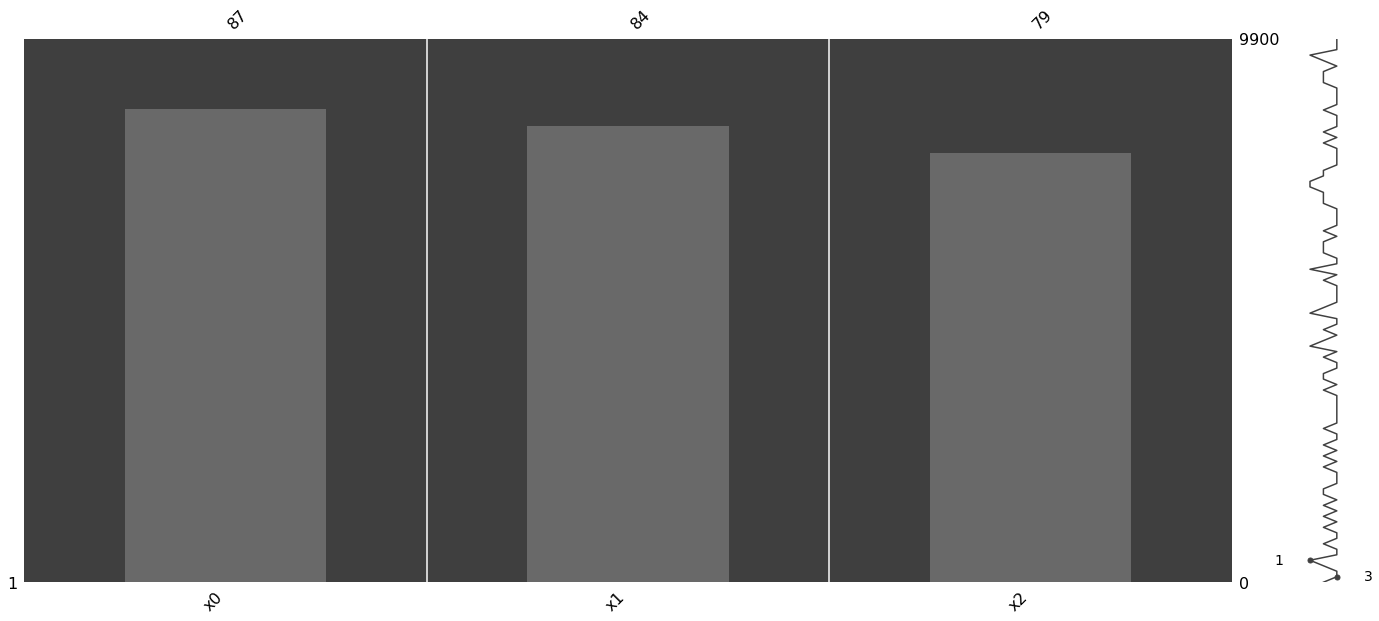

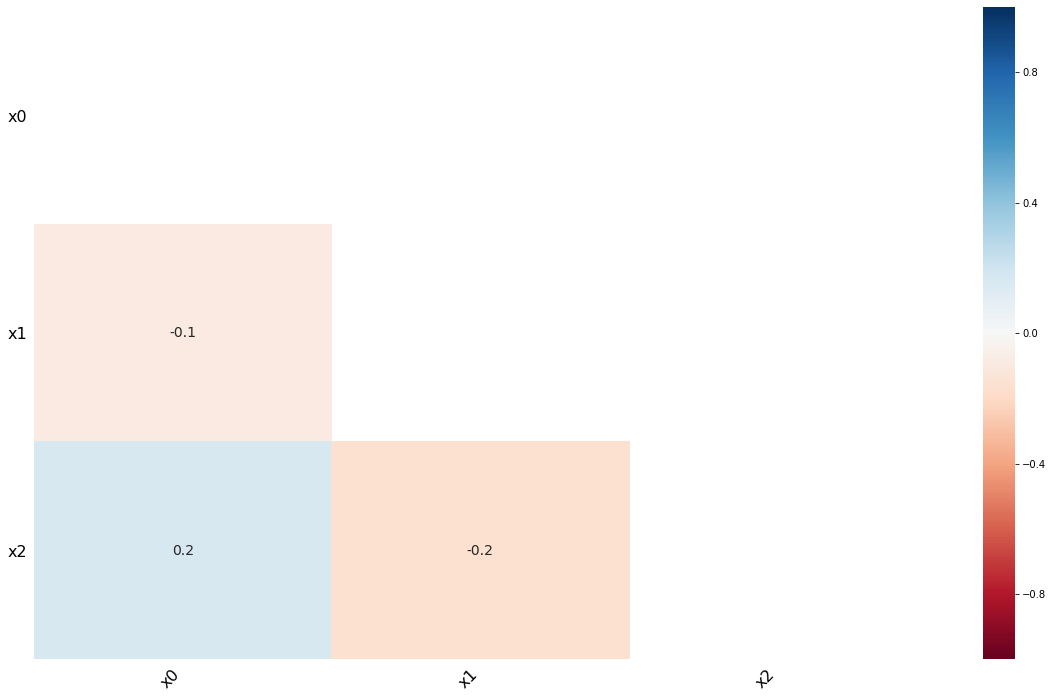

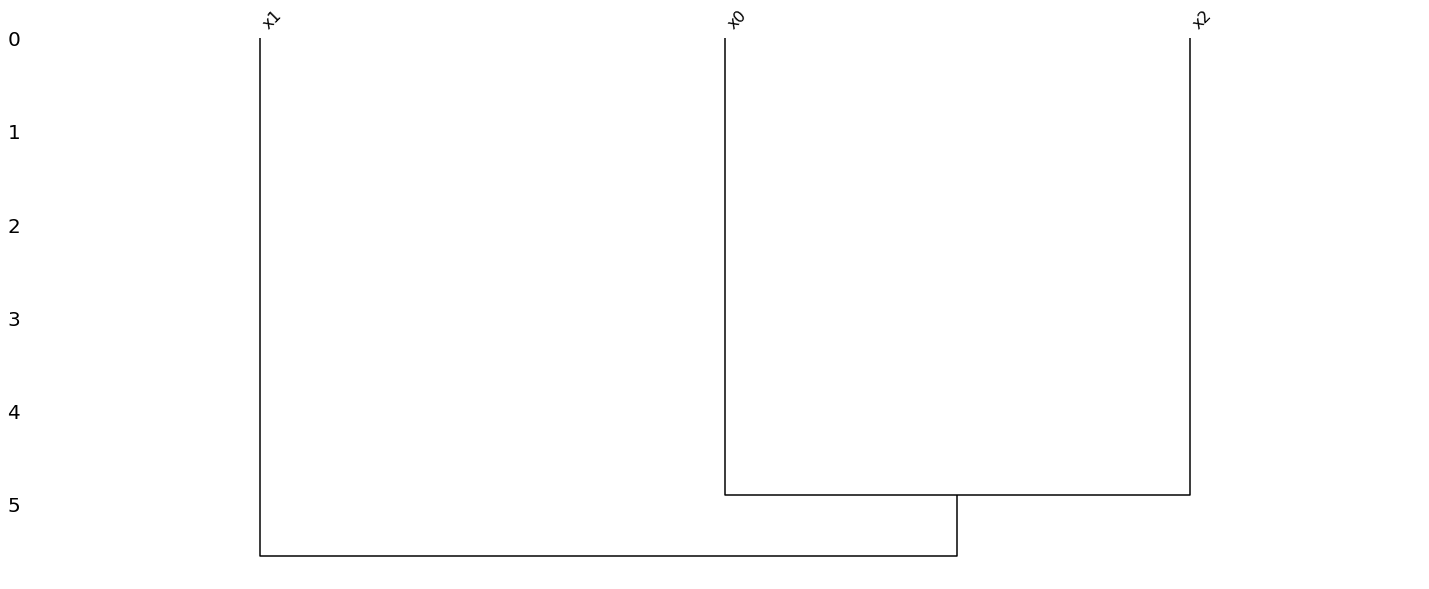

In [4]:
import missingno as msno
import matplotlib
import pandas as pd

data_df = pd.DataFrame(m_data, columns=['x{}'.format(c) for c in range(data.shape[1])])

msno.matrix(data_df)
msno.bar(data_df)
msno.heatmap(data_df)
msno.dendrogram(data_df)

### Imputation

Let's impute the missing data using several different techniques.

In [5]:
import warnings
from fancyimpute import KNN
from fancyimpute import NuclearNormMinimization
from fancyimpute import SoftImpute
from fancyimpute import IterativeImputer
from fancyimpute import BiScaler

with warnings.catch_warnings(record=True):
    ii_data = IterativeImputer(verbose=0).fit_transform(m_data)
    nn_data = KNN(k=7, verbose=False).fit_transform(m_data)
    bs_data = BiScaler(verbose=False).fit_transform(m_data)
    si_data = SoftImpute(verbose=False).fit_transform(bs_data)

Using TensorFlow backend.


### Performance

Let's observe the performances of the imputation techniques.

In [6]:
def get_mse(f_data, i_data, null_indices):
    t = []
    for pair in null_indices:
        r, c = pair[0], pair[1]
        v1 = f_data[r][c]
        v2 = i_data[r][c]
        diff = np.power(v1 - v2, 2.0)
        # print('{:.10f}, {:.10f}, {:.10f}'.format(v1, v2, diff))
        t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

def get_mean_mse(f_data, i_data):
    m1 = np.mean(f_data, axis=0)
    m2 = np.mean(i_data, axis=0)
    num_means = len(m1)
    t = []
    for i in range(num_means):
        v1 = m1[i]
        v2 = m2[i]
        diff = np.power(v1 - v2, 2.0)
        t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

def get_cov_mse(f_data, i_data):
    cov1 = np.cov(f_data.T)
    cov2 = np.cov(i_data.T)
    num_rows, num_cols = cov1.shape[0], cov1.shape[1]
    t = []
    for r in range(num_rows):
        for c in range(num_cols):
            v1 = cov1[r][c]
            v2 = cov2[r][c]
            diff = np.power(v1 - v2, 2.0)
            t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
s_data = scaler.fit_transform(data)

perfs = pd.DataFrame([(get_mse(data, ii_data, null_indices), 
          get_mean_mse(data, ii_data), 
          get_cov_mse(data, ii_data)), 
         (get_mse(data, nn_data, null_indices),
          get_mean_mse(data, nn_data),
          get_cov_mse(data, nn_data)), 
         (get_mse(s_data, si_data, null_indices),
          get_mean_mse(s_data, si_data),
          get_cov_mse(s_data, si_data))], 
        columns=['MSE', 'Average MSE', 'Covarance MSE'], 
        index=['Iterative Imputer', 'KNN Imputer', 'Soft Imputer'])

perfs

,MSE,Average MSE,Covarance MSE
Iterative Imputer,0.886951,0.003314,0.008129
KNN Imputer,1.338415,0.003687,0.005270
Soft Imputer,0.988587,0.000258,0.115665


## Randomly generated example

### Synthetic data

Now we generate a dataset of 10 random variables with the parameters (means and covariance matrix) generated randomly (as opposed to manually specified as before). We go through the whole process of 

* parameter generation,
* data generation,
* missing data creation, and
* imputation.

We then visualize the missingness, followed by computing the performances of the imputation techniques.

In [8]:
num_vars = 10

means = np.array([np.random.randint(20, 100) for i in range(num_vars)], dtype=np.float64)
cov = []
for i in range(num_vars):
    for j in range(num_vars):
        if i == j:
            cov.append(1.0)
        else:
            cov.append(np.random.randint(1, 10))

with warnings.catch_warnings(record=True):
    cov = np.array(cov, dtype=np.float64).reshape((num_vars, num_vars))
    data = np.random.multivariate_normal(means, cov, 500)

    null_indices = get_null_indices(data.shape[0], data.shape[1], num_nulls=1000)
    m_data = knockout_data(data, null_indices)

### Imputation

In [9]:
with warnings.catch_warnings(record=True):
    ii_data = IterativeImputer(verbose=0).fit_transform(m_data)
    nn_data = KNN(k=7, verbose=False).fit_transform(m_data)
    bs_data = BiScaler(verbose=False).fit_transform(m_data)
    si_data = SoftImpute(verbose=False).fit_transform(bs_data)

    scaler = StandardScaler()
    s_data = scaler.fit_transform(data)

### Visualize

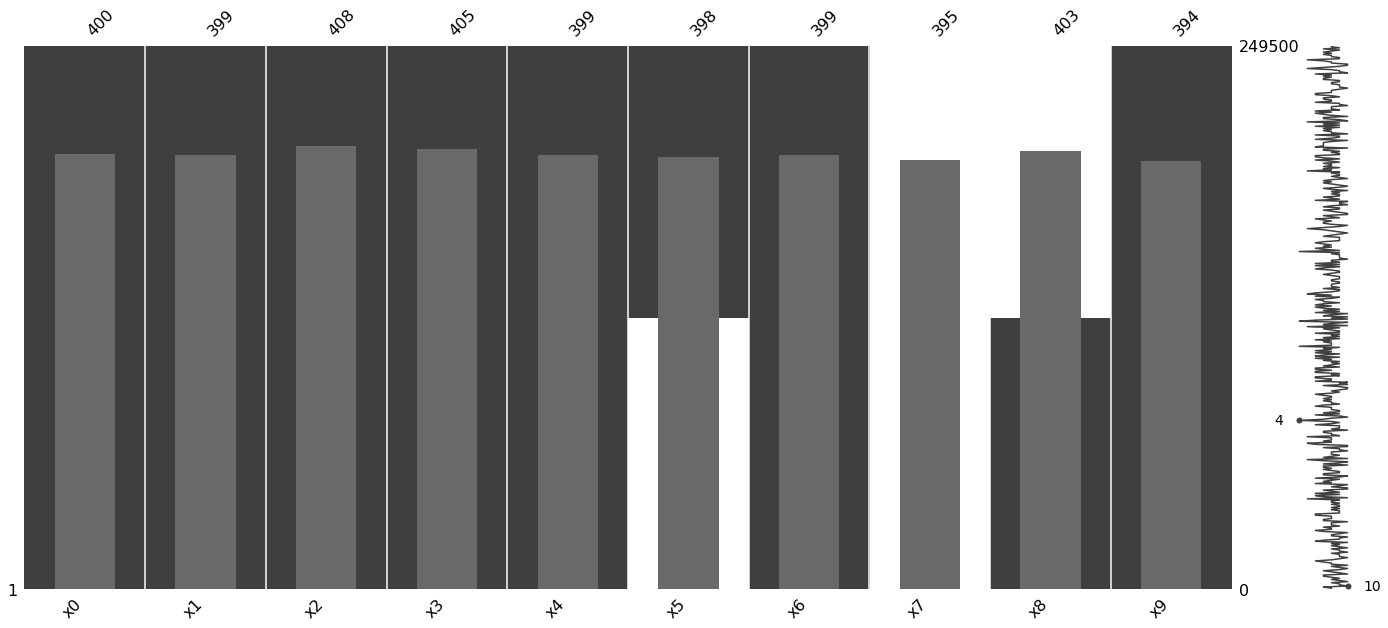

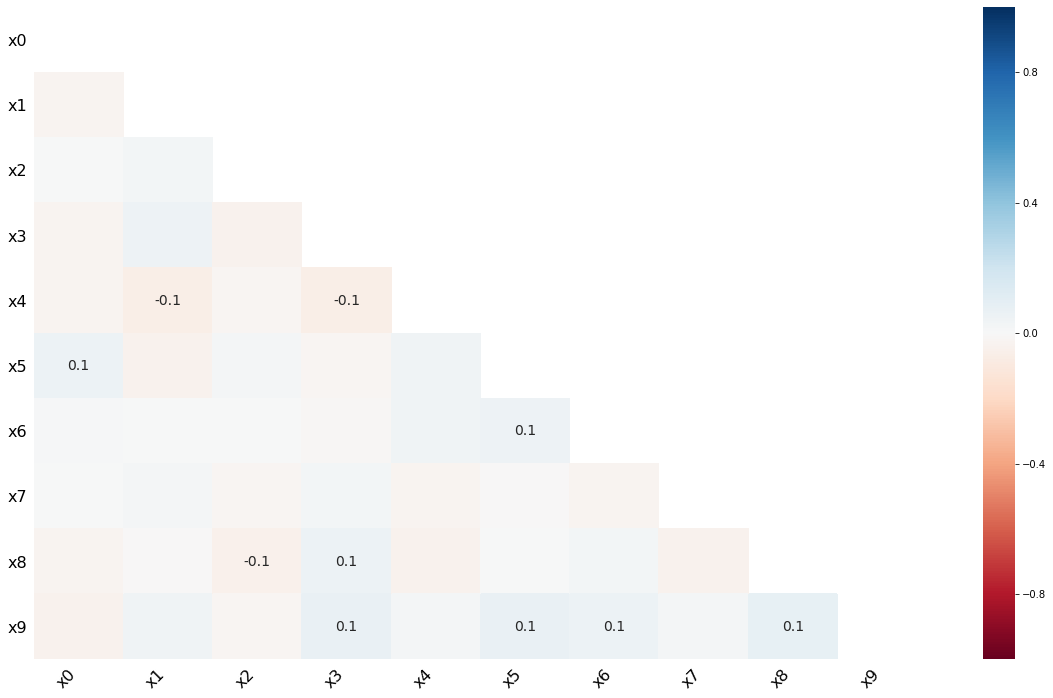

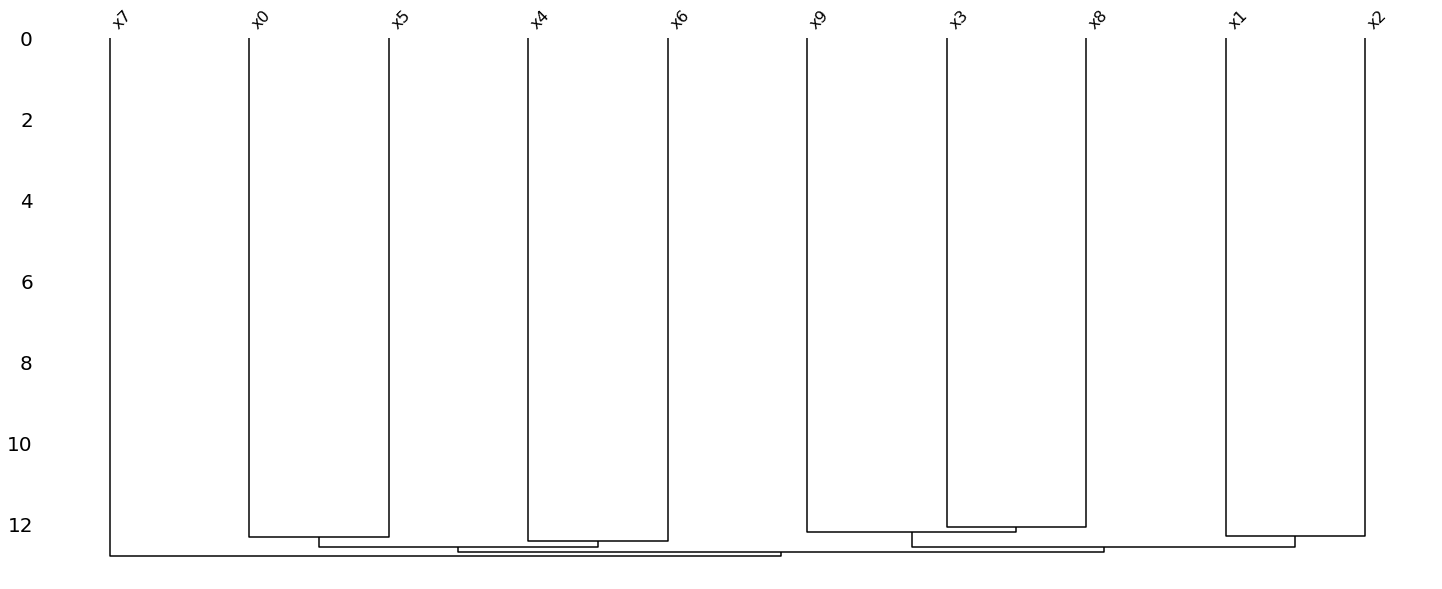

In [10]:
data_df = pd.DataFrame(m_data, columns=['x{}'.format(c) for c in range(data.shape[1])])
msno.matrix(data_df)
msno.bar(data_df)
msno.heatmap(data_df)
msno.dendrogram(data_df)

### Performance

As can be seen below, iterative imputation seems to do the best by perserving the mean of each variable and also the covariance. 

In [11]:
scaler = StandardScaler()
s_data = scaler.fit_transform(data)

perfs = pd.DataFrame([(get_mse(data, ii_data, null_indices), 
          get_mean_mse(data, ii_data), 
          get_cov_mse(data, ii_data)), 
         (get_mse(data, nn_data, null_indices),
          get_mean_mse(data, nn_data),
          get_cov_mse(data, nn_data)), 
         (get_mse(s_data, si_data, null_indices),
          get_mean_mse(s_data, si_data),
          get_cov_mse(s_data, si_data))], 
        columns=['MSE', 'Average MSE', 'Covarance MSE'], 
        index=['Iterative Imputer', 'KNN Imputer', 'Soft Imputer'])

perfs

,MSE,Average MSE,Covarance MSE
Iterative Imputer,6.542703,0.001914,0.141343
KNN Imputer,8.686041,0.007308,0.623918
Soft Imputer,0.909642,0.000009,0.184934
